<img src="https://github.com/Fortuz/edu_Adaptive/blob/main/practices/assets/logo.png?raw=1" width="800">

Made by **Balázs Nagy** and **Márk Domokos**

[<img src="https://github.com/Fortuz/edu_Adaptive/blob/main/practices/assets/open_button.png?raw=1">](https://colab.research.google.com/github/Fortuz/edu_Adaptive/blob/main/practices/L04%20-%20Regularized%20Logistic%20Regression%20(NonLinear%20case)_solved.ipynb)

# Labor 04: Regularized Logistic Regression (Non-Linear case)

### Microchip Anomaly:

Our task is to determine which of the microchips are defective and which are not, based on the measurement results.

In this exercise we will work with a non-linearly separable data set. We want to use logistic regression for classification, so we extend the non-linear case by introducing more features (polynomial regression).

In this exercise we will test different regularization parameters to better understand how regularization (penalty) works and how it can be used to prevent overfitting. Observe the changes in the decision boundary as the lambda will be changed. With a small lambda you will notice that there is almost no error in the clustering, but in return you get a very complicated curve. This is not a good decision curve, notice that it accepts (-0.25; 1.5), which seems to be an incorrect decision based on our data set.

Using a larger lambda we can see that a simpler decision boundary is created that does not follow the data as closely so it is underfitted.

### 1: Import neccessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 2: Load data

The data will be loaded from a publicly available file. An alternative solution would be to upload the data file directly to the google colab file system.

In [2]:
!wget https://github.com/Fortuz/edu_Adaptive/raw/main/practices/assets/Lab04/Lab4data.txt

--2024-11-13 08:39:12--  https://github.com/Fortuz/edu_Adaptive/raw/main/practices/assets/Lab04/Lab4data.txt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Fortuz/edu_Adaptive/main/practices/assets/Lab04/Lab4data.txt [following]
--2024-11-13 08:39:14--  https://raw.githubusercontent.com/Fortuz/edu_Adaptive/main/practices/assets/Lab04/Lab4data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2233 (2.2K) [text/plain]
Saving to: ‘Lab4data.txt’

Lab4data.txt        100%[===================>]   2.18K  --.-KB/s    in 0.001s  

2024-11-13 08:39:14 (1.95 MB/s) - ‘Lab4data.txt’ saved [2233/2233]



Load in the data! Use the Pandas package to do this and then convert it into a numpy array.

In [3]:
data = pd.read_csv('Lab4data.txt', header = None).to_numpy()
X = data[:,0:2]
m,n = X.shape
Y = data[:,2].reshape(m,1)
del data

print('X:', X.shape)
print('Y:', Y.shape)
print('Number of data points:',m)
print('Number of features:',n)

X: (118, 2)
Y: (118, 1)
Number of data points: 118
Number of features: 2


Plot the elements based on whether they passed the test or not.

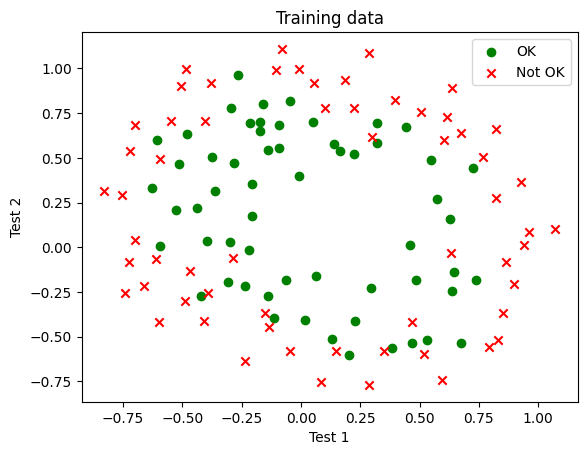

In [4]:
def plotData(X,Y):
    pos = []
    neg = []

    for i in range(0,Y.size):
        if Y[i]==1:
            pos.append(X[i,:])
        elif Y[i]==0:
            neg.append(X[i,:])

    pos = np.array(pos)
    neg = np.array(neg)

    plt.scatter(pos[:, 0], pos[:, 1], c="g", marker="o", label="OK")
    plt.scatter(neg[:, 0], neg[:, 1], c="r", marker="x", label="Not OK")
    plt.title("Training data")
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.legend()
    plt.show()

    return pos,neg

pos, neg = plotData(X,Y)

We can see that our data are not linearly separable. <br>
Since our data fall within the interval $[-1, 1]$ for both variables with a fairly good distribution, the data set does not require further normalization.

### 3: Theoretical background: Model Fit on Data

In terms of model fit for the samples, we can distinguish 3 different cases.

- Underfit (or High Bias) is when the model is too simple and therefore causes a large error on both the training data and the test data.

- It is a good fit when we get low error on both the training data and the test data. This means that the learning process has succeeded in learning the relevant information that allows the new patterns to be classified well enough.

- Overfit (or High Variance) if the model has learned the training patterns specifically during the training. This results in a very low error rate during learning, but a high error rate when classifying samples not included in the training data set.

<img src="https://github.com/Fortuz/edu_Adaptive/blob/main/practices/assets/Lab04/Pics/L04_Fittings.png?raw=1" width="800">

The Underfit and Overfit phenomena during a typical learning run. The goal would be to stop learning at the point where the validation error is the smallest.

<img src="https://github.com/Fortuz/edu_Adaptive/blob/main/practices/assets/Lab04/Pics/L04_BiasVariance.png?raw=1" width="400">

In practice, we divide our available data into 3 groups if we have a large enough sample size.
- Training set (~70%): data used during training to set the weights of the moddell
- Validation set (~15%): Stop learning at the appropriate epoch, hyperparameter optimization
- Test set (~15%): Test on independent data, define metrics

In this example, we are working with a small data set, so we will not split the data in this way. Theoretical insight will help to understand.

#### Methods to deal with Underfit and Overfit cases:

For underfit, our model is too simple. Suitable compensation can be: <br>
- Increase the number of features
- Chose a more complex model

In the case of overfit, our model learns the training data too specifically. Suitable compensation can be: <br>
- Decrease the number of features
- Chose a more simpler model
- Regularization

In the case of regularization, the guiding principle is: starting from a complex model (e.g.: multiple variables), the algorithm has many possibilities, thus the underfit phenomenon is most likely handled. And by extending the cost function, we penalize if the model uses too many variables. In this way, we create the optimal condition for the simplest model to solve the problem.

### 4: Input feature expansion

In the microchip test example the two test results are the input variables. To solve the desired problem more variables are needed. One possible way to do this is to increase the input variables by the powers of the original variables.

$x_1,\  x_2 \Rightarrow\ 1,\ x_1,\ x_2,\ x_1^2,\ x_1x_2,\ x_2^2,\ x_1^3,\ x_1^2x_2,\ x_1x_2^2,\ x_2^3$

By expanding the input variables to the 3rd power, including the BIAS term, we can count 10 variables instead of the initial 2.

Let's create the mapFeature() function that performs the above mapping.

In [27]:
def mapFeature(X1,X2,deg):
    ################### CODE HERE ########################
    # Implement the map feature function
    x1_powers = np.array([X1**i for i in range(1, deg + 1)]).T
    x2_powers = np.array([X2**i for i in range(1, deg + 1)]).T
    out = np.concatenate((np.ones((x1_powers.shape[0],1)), x1_powers, x2_powers), axis=1)
    ######################################################
    return out

In [28]:
deg = 3
X=mapFeature(X[:,0], X[:,1], deg)
print(X.shape)

(118, 7)


Once the input variables have been expanded, we can move on to the construction of the cost function.

### 5: Cost function and Gradient Descent Method

The activation function will be the sigmoid function, as we have used it in the previous labs.

The cost function will be augmented with a penalty term, according to the formula below:

$ C(w)=\frac{1}{2m}\sum_{i=1}^m(h_w(x^i)-y^i)^2+\lambda\sum_{\color{red}{j=1}}^nw_{\color{red}{j}}^2 $

, where <br>
$ \lambda $ is the parameter setting the penalty rate <br>
$ i $ is the index starting from 1. $i = 1...n$ <br>
$ j $ is the index of the input variables starting from 0 $\color{red}{ j = 0...m}$ <br>

What to look out for to ensure that BIAS is not penalised. The weight $ \color{red}{w_0}$ connected to the $x_{\color{red}{0}} = 1 $ BIAS should not be taken into account when calculating the penalty.

Setting the $ \lambda $ value too high can lead to an underfit


!! its the binary case with log likely hood not the multivariate!

Let's consider how the cost function with the regularization term extended to the multivariate case and how it will fit into the gradient descent method.

$ C(w)=-\frac{1}{m}\sum_{i=1}^{m}y^i\cdot log(h_w(x^i))+(1-y^i)\cdot log(1-h_w(x^i))+\frac{\lambda}{2m}\sum_{j=1}^nw_j^2 $

For ease of derivation, the constant in the regularizing term contains $\frac{\lambda}{2m}$ instead of $ \lambda $ .

Basic formula for the weight update of the Gradient Descent method:

$ w_j = w_j - \mu \color{green}{\frac{\partial}{\partial w_j}C(w)}$

When calculating the derivative of the cost function, the BIAS case should be treated separately. Let us examine the case of $w_0$ and $w_1$.

$ \color{green}{\frac{\partial}{\partial w_0}C(w)}=\frac{1}{m}\sum_{i=1}^{m}(h_w(x^i)-y^i)\cdot x_0^i+{\color{red} 0}$

$ \color{green}{\frac{\partial}{\partial w_j}C(w)}=\frac{1}{m}\sum_{i=1}^{m}(h_w(x^i)-y^i)\cdot x_j^i+\frac{\lambda}{m}w_j $

Taking advantage of the similarities, consider how the cost function and the gradient could be calculated in a function using matrix operations. <br>
Implement the costFunctionReg().

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def costFunctionReg(w,X,Y,Lambda=1):
    ################### CODE HERE ########################
    # Implement the cost functon with regularization
    # First calculate the so called hipothesis.
    # Remember that the BIAS is not penalized. Make sure to exclude the BIAS.
    # Calculate the Logistic Regression Cost with the additional penalty.
    # Calculate the gradiens as well.









    ######################################################

    return C,grad

In [ ]:
init_w = np.zeros((X.shape[1],1))                   # init weights with zero
C, grad =costFunctionReg(init_w,X,Y)
print('Expected cost at initial weight (zeros): 0.693')
print('Calculated cost at initial weight (zeros): %.4f' % C[0,0])

After the successful implementation of the cost function and the calculation of the gradients, the weights can be modified. <br>

Basic weight modification formula for Gradient Descent algorithm:

$w_j:=w_j-\mu\frac{\partial}{\partial w_j}C(w)$

Implement the gradientDescent() function. Use costFunctionReg() and save the cost of each epoch within the function.

In [ ]:
def gradientDescent(X,Y,w,learning_rate,num_iters,Lambda):
    C_history = []

    ################### CODE HERE ########################
    # Implement the gradient descent alorithm







    #####################################################

    return w, C_history

Let us examine how the learning rate (or $\mu$) and the regularization parameter ($\lambda$) affect the evolution of the cost function.

Experiment with different learning rate parameter settings to see what happens with the learning curve.

In [ ]:
learning_rate = 1
epoch = 800
Lambda = 0.02

w, C_history = gradientDescent(X,Y,init_w,learning_rate,epoch,Lambda)
print('\nRegularized weight:\n',w)

plt.plot(C_history,label = "C_history")
plt.title("Cost function trough the iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.legend()
plt.show()

### 6: Visualization

Plot the decision boundary on the original data series.

In [ ]:
plt.scatter(pos[:, 0], pos[:, 1], c="g", marker="o", label="OK")
plt.scatter(neg[:, 0], neg[:, 1], c="r", marker="x", label="Not OK")

u_vals = np.linspace(-1,1.,50)
v_vals = np.linspace(-1,1.,50)
z=np.zeros((len(u_vals),len(v_vals)))

for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] = mapFeature(u_vals[i],v_vals[j],deg) @ w

plt.contour(u_vals,v_vals,z.transpose(),0)
plt.title("Decision boundary and the training data")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.show()

### 7: Accuracy of the prediction

Run the prediction on multiple input instances and observ the overall accuracy by summing up the results.

In [ ]:
def classificationPrediction(w,X):
    pred = (sigmoid(X @ w) > 0.5)
    return ((np.sum(pred==Y)/m)*100)

acc=classificationPrediction(w,X)
print('\nAccuracy of the classification:',acc, '%')

<div style="text-align: right">This lab exercise uses elements from Andrew Ng's Machine Learning course.</div>